In [ ]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import os

import numpy as np


In [ ]:
class LSGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model(z, valid)
        # (!!!) Optimize w.r.t. MSE loss instead of crossentropy
        self.combined.compile(loss='mse', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        # (!!!) No softmax
        model.add(Dense(1))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("/img_folder_path/%d.png" % epoch) # customize your image folder path
        plt.close()

In [ ]:
gan = LSGAN()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-trai

In [4]:
gan.train(epochs=30000, batch_size=32, sample_interval=200)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 13ms/step
27506 [D loss: 0.253853, acc.: 53.12%] [G loss: 0.424384]
1/1 [==============================] - 0s 12ms/step
27507 [D loss: 0.183254, acc.: 71.88%] [G loss: 0.498199]
1/1 [==============================] - 0s 13ms/step
27508 [D loss: 0.232869, acc.: 62.50%] [G loss: 0.493975]
1/1 [==============================] - 0s 13ms/step
27509 [D loss: 0.204348, acc.: 65.62%] [G loss: 0.439634]
1/1 [==============================] - 0s 13ms/step
27510 [D loss: 0.192993, acc.: 71.88%] [G loss: 0.461404]
1/1 [==============================] - 0s 13ms/step
27511 [D loss: 0.244413, acc.: 53.12%] [G loss: 0.456270]
1/1 [==============================] - 0s 13ms/step
27512 [D loss: 0.217158, acc.: 68.75%] [G loss: 0.530181]
1/1 [==============================] - 0s 13ms/step
27513 [D loss: 0.239296, acc.: 54.69%] [G loss: 0.465384]
1/1 [==============================] - 0s 12ms/step
27514 [D loss: 0.250806, acc.: 6

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

In [8]:
import imageio
import tensorflow_docs
import PIL
import glob
from IPython import display

In [5]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('/img_folder_path/{:04d}.png'.format(epoch_no))

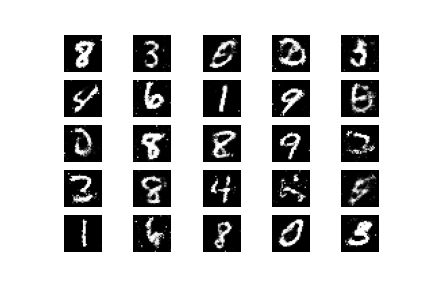

In [6]:
display_image(29800)

In [9]:
anim_file = 'lsgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/img_folder_path/*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


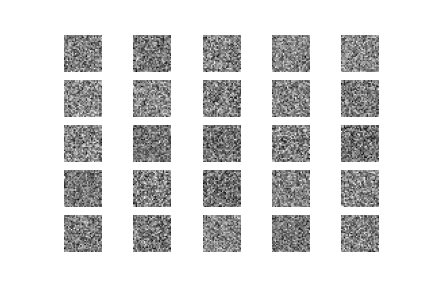

In [10]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)